## Imports

In [259]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import json
import os # operating system

## Reading the data

In [260]:
file_name = 'XY_train.csv'
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'XY_train.csv')
df = pd.read_csv(file_path).drop(columns = ['ID'])
df.head()

,GENDER,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,PAST_ACCIDENTS,AGE,DRIVING_EXPERIENCE,OUTCOME
0,female,high school,upper class,0.545417,1,after 2015,1,1,10238,8000.0,sedan,4,6,80,39,0
1,male,none,poverty,0.361876,0,before 2015,1,1,10238,9000.0,sedan,0,0,26,2,1
2,female,university,middle class,0.535840,1,before 2015,1,0,10238,12000.0,sedan,0,0,29,7,0
3,female,high school,upper class,0.612545,1,after 2015,1,0,32765,9000.0,sedan,3,0,60,13,0
4,male,university,middle class,0.474268,1,before 2015,0,0,32765,13000.0,sedan,0,0,52,0,1


## Graphs

### Dataset balance

In [261]:
def create_histogram_of_priopr_probs_for_outcome(column: pd.Series) -> plt.figure:
    counts = column.value_counts(normalize=True)
    fig, ax = plt.subplots(figsize=(8, 6))
    counts.plot(kind='bar', color=['Purple', 'lightblue'])
    for i, value in enumerate(counts):
        percentage = f"{value * 100:.1f}%"  # Format as percentage
        ax.text(i, value, percentage, ha='center', va='bottom', fontsize=10)
    
    ax.set_title(f'Prior Probabilities of {column.name}')
    ax.set_xlabel(column.name)
    ax.set_ylabel('Probability')
    plt.ylim(0, 1.1)  # Adjust y-axis to give space for text
    return fig

def create_donut_chart_for_variable_count(column : pd.Series):
    variable_counts = column.value_counts(normalize=True)
    column_name = column.name
    plt.figure(figsize=(8, 6))
    variable_counts.plot(kind='pie', autopct='%1.1f%%', colors=['purple', 'lightblue'], startangle=90, wedgeprops={'width': 0.3})
    plt.title('Prior Probabilities of ' + column_name)
    plt.ylabel('')  # Remove y-axis label   

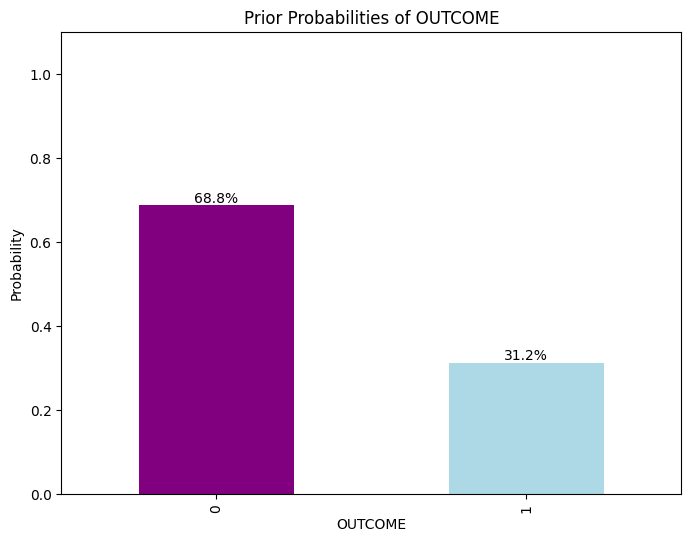

In [262]:
histogram_of_prob_outcome = create_histogram_of_priopr_probs_for_outcome(df['OUTCOME'])
plt.show()

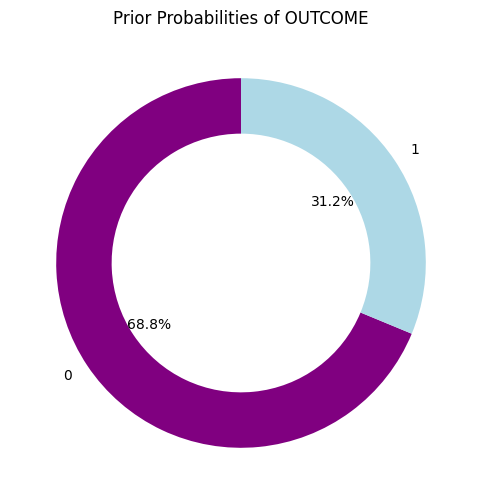

In [263]:
create_donut_chart_for_variable_count(df['OUTCOME'])
plt.show()

### Histogram Plots

In [264]:
def create_histogram_per_column(column: pd.Series) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(8, 6))
    bins = 20 if column.name == 'ANNUAL_MILEAGE' else range(column.min(), column.max() + 2)
    ax.hist(column, bins=bins, edgecolor='k', alpha=0.7)
    ax.set_title('Distribution of ' + column.name, fontsize=14)
    ax.set_xlabel(column.name, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(False)
    return fig

def hist_mean_srdv_per_column(column: pd.Series):
    print(f"Statistics for: {column.name}")
    mean = column.mean()
    std = column.std()
    print(f"Mean: {mean:.2f}")
    print(f"Standard Deviation: {std:.2f}")
    print()

In [265]:
def create_hist_grid(contious_columns):
    n_cols = 3 
    n_rows = -(-len(contious_columns) // n_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case it's a 2D array

    # Plot histograms
    for i, col in enumerate(contious_columns):
        axes[i].hist(df[col].dropna(), bins=20, color='blue', edgecolor='black', alpha=0.7)  # Drop NaNs
        axes[i].set_title(col)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    # Remove unused subplots if columns < grid size
    for j in range(len(contious_columns), len(axes)):
        fig.delaxes(axes[j])  # Delete unused subplot spaces

    # Adjust layout
    plt.tight_layout()
    plt.show()

Statistics for: DRIVING_EXPERIENCE
Mean: 15.36
Standard Deviation: 10.53



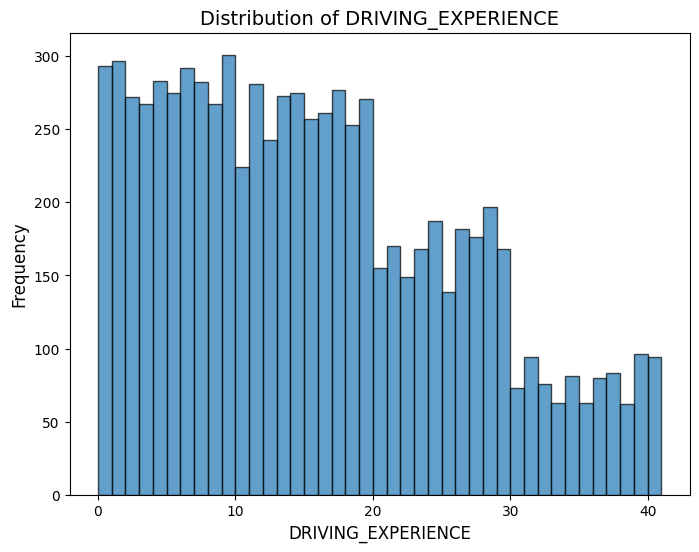

In [266]:
driving_exp = create_histogram_per_column(df['DRIVING_EXPERIENCE'])
hist_mean_srdv_per_column(df['DRIVING_EXPERIENCE'])
plt.show()

Statistics for: AGE
Mean: 43.75
Standard Deviation: 18.98



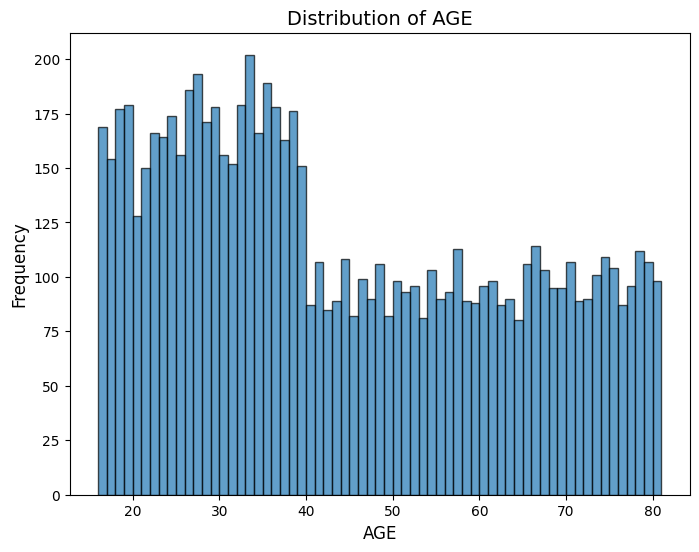

In [267]:
age_hist = create_histogram_per_column(df['AGE'])
hist_mean_srdv_per_column(df['AGE'])
plt.show()

Statistics for: PAST_ACCIDENTS
Mean: 1.08
Standard Deviation: 1.67



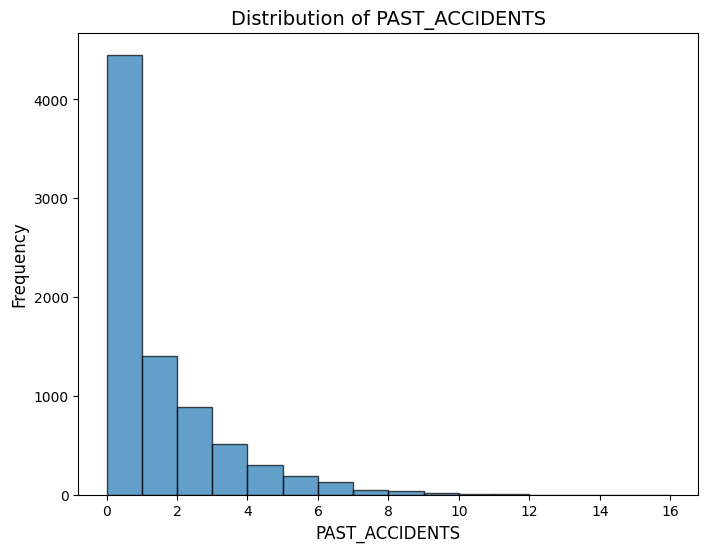

In [268]:
past_acc = create_histogram_per_column(df['PAST_ACCIDENTS'])
hist_mean_srdv_per_column(df['PAST_ACCIDENTS'])
plt.show()

Statistics for: ANNUAL_MILEAGE
Mean: 11694.74
Standard Deviation: 2815.76



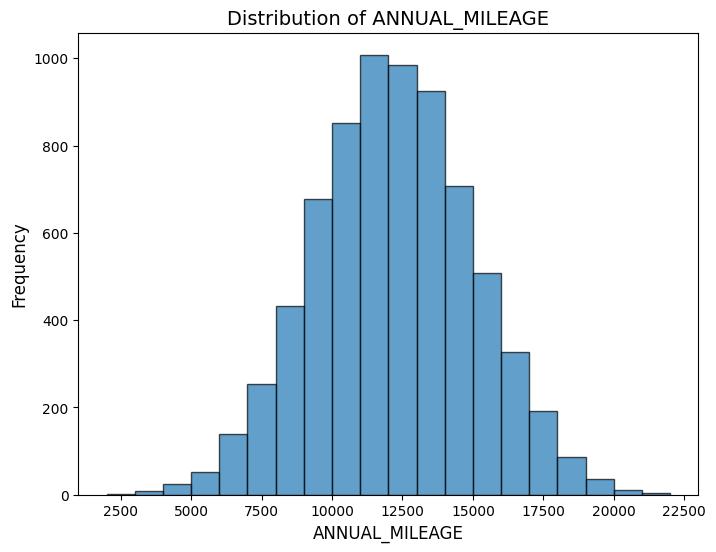

In [269]:
annual_mileage = create_histogram_per_column(df['ANNUAL_MILEAGE'])
hist_mean_srdv_per_column(df['ANNUAL_MILEAGE'])
plt.show()

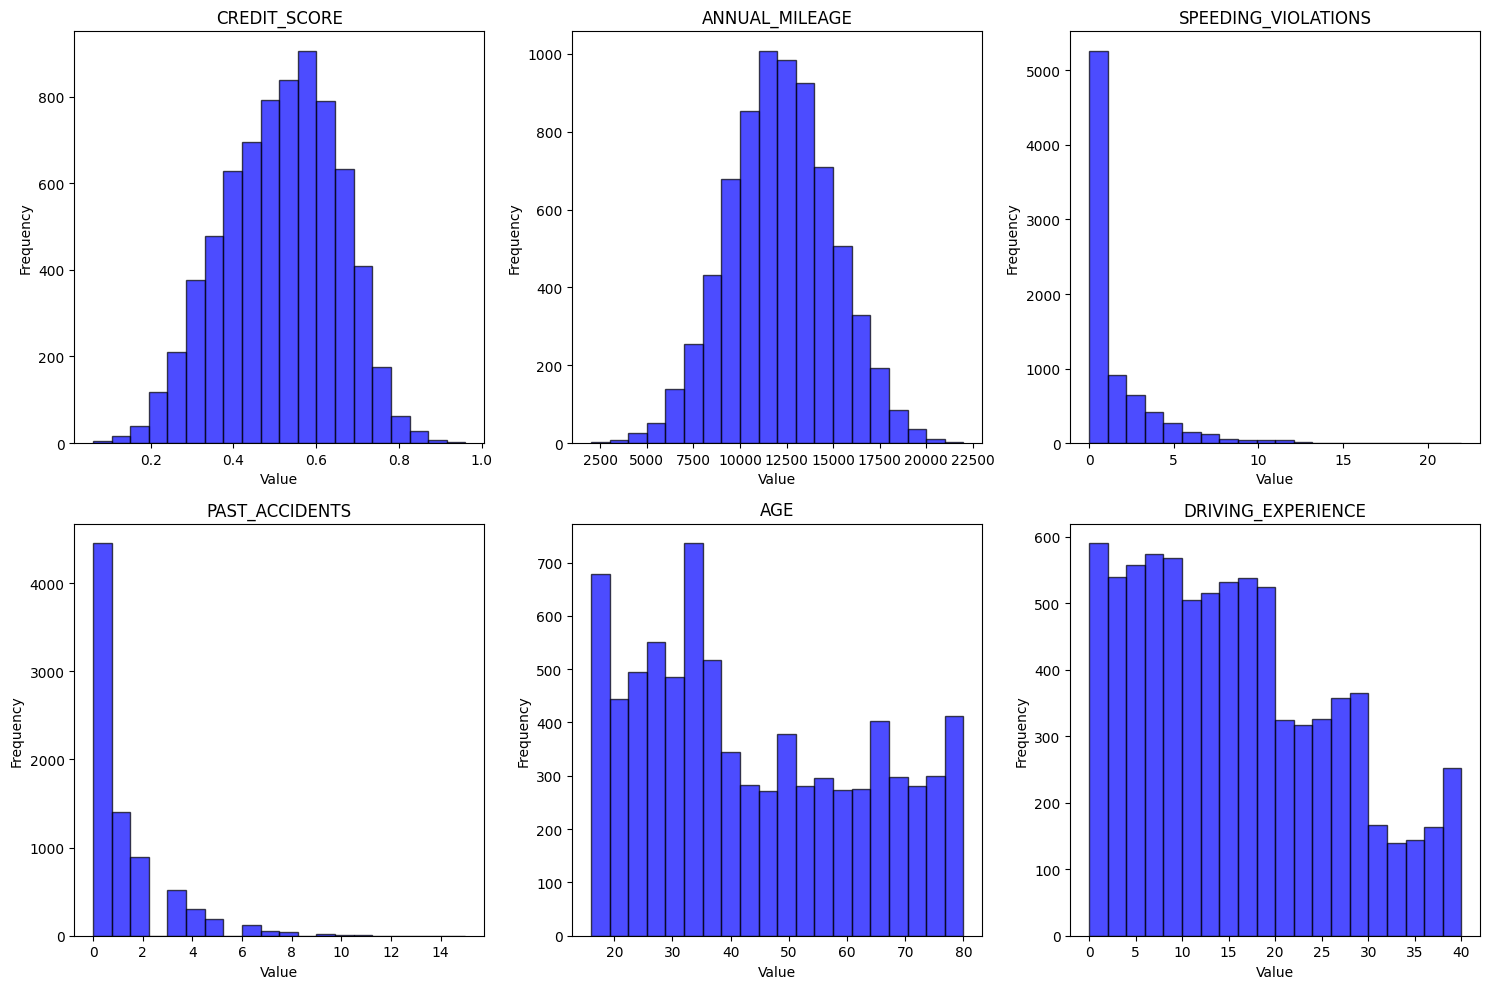

In [270]:
contious_columns = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS', 'AGE', 'DRIVING_EXPERIENCE']
create_hist_grid(contious_columns)

We can see that:
1. credit_score, annual_mileage are sort of normal distribution
2. speed_violations, past_accidents are sort of exp distribution
3. age, driving_experience are sort of uniform

We'll take this into consider when descritizing

In [271]:
def create_correlation_heat_map(df: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Correlation Matrix Heatmap', fontsize=14)
    plt.show()

### Interesting Relations

In [272]:
def create_scatter_plot_for_two_columns (column1: pd.Series, column2: pd.Series) -> plt.figure:
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.regplot(x=column1, y=column2, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    ax.set_title(f'{column1.name} vs. {column2.name}', fontsize=14)
    ax.set_xlabel(column1.name, fontsize=12)
    ax.set_ylabel(column2.name, fontsize=12)
    ax.grid(False)
    return fig

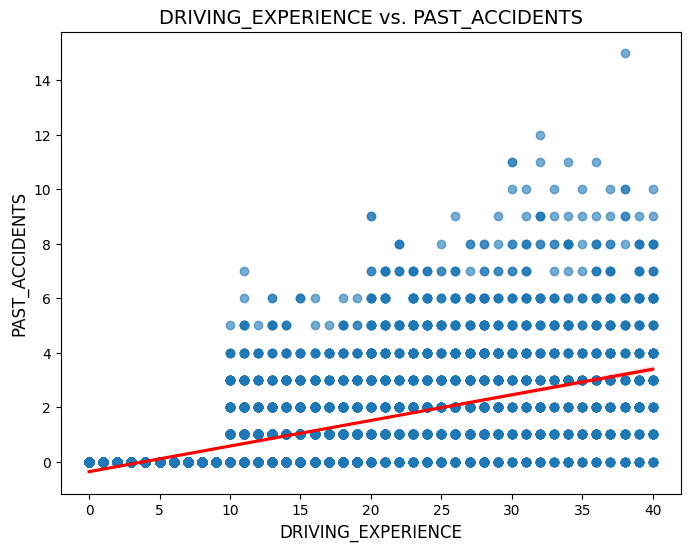

In [273]:
scatter_driving_past_accidents = create_scatter_plot_for_two_columns(df['DRIVING_EXPERIENCE'], df['PAST_ACCIDENTS'])
plt.show()

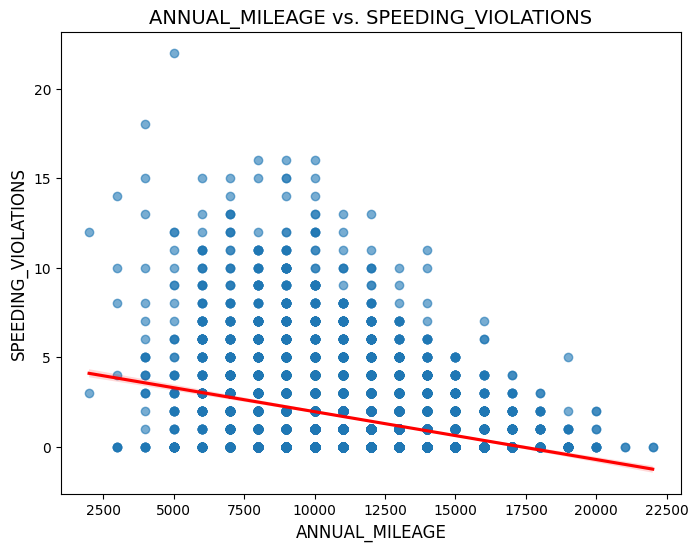

In [274]:
scatter_annual_speeding_violations = create_scatter_plot_for_two_columns(df['ANNUAL_MILEAGE'], df['SPEEDING_VIOLATIONS'])
plt.show()

### BoxPlots

In [275]:
def create_boxplot_for_2_columns (column1: pd.Series, column2: pd.Series) -> plt.figure:
    sns.boxplot(hue=column1, y=column2, palette='Set3')
    plt.title(f'{column2.name} Distribution by {column1.name}', fontsize=14)
    plt.xlabel(column1.name, fontsize=12)
    plt.ylabel(column2.name, fontsize=12)
    plt.show()

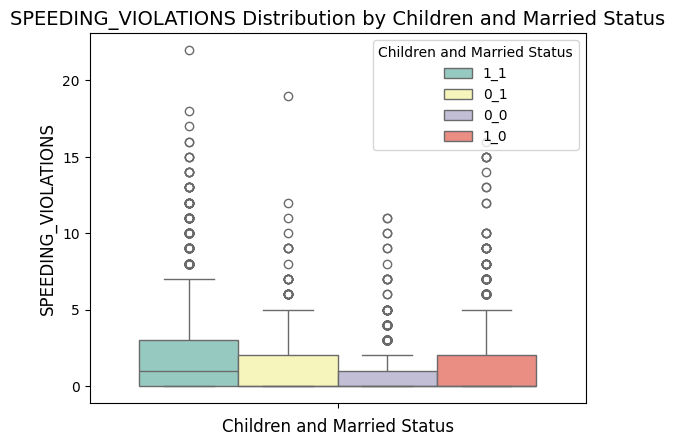

In [276]:
combined_column = df['CHILDREN'].astype(str) + '_' + df['MARRIED'].astype(str)
combined_column.name = 'Children and Married Status'
boxplot_married_and_children_by_speeding_violations = create_boxplot_for_2_columns(combined_column , df['SPEEDING_VIOLATIONS'])
plt.show()

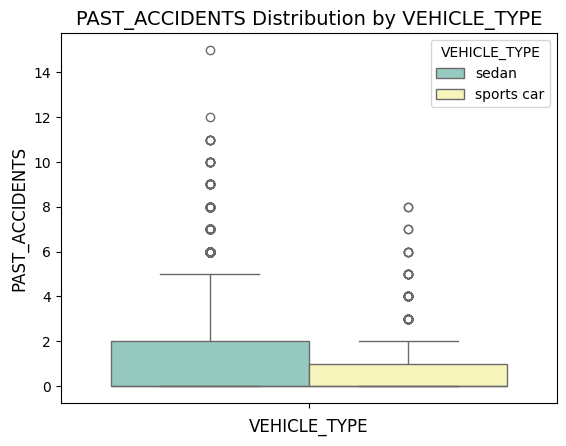

In [277]:
boxplot_vehicletype_accidents = create_boxplot_for_2_columns(df['VEHICLE_TYPE'], df['PAST_ACCIDENTS'])
plt.show()

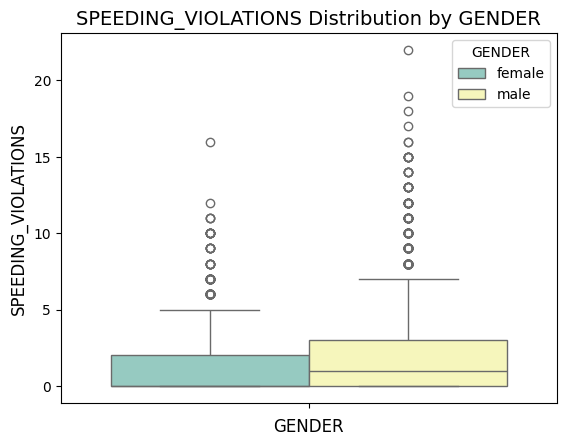

In [278]:
boxplot_gender_speeding_violations = create_boxplot_for_2_columns(df['GENDER'], df['SPEEDING_VIOLATIONS'])
plt.show()

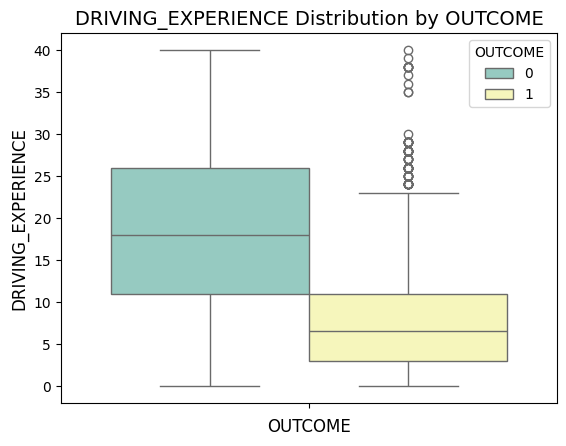

In [279]:
boxplot_outcome_driving_experience = create_boxplot_for_2_columns(df['OUTCOME'], df['DRIVING_EXPERIENCE'])
plt.show()

### Violin Plots

In [280]:
def create_violin_plot_of_2_columns(column1: pd.Series, column2: pd.Series):    
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        hue = column1,
        y=column2,
        palette='coolwarm'
    )
    plt.title(f'Violin Plot of {column2.name} by {column1.name}', fontsize=14)
    plt.xlabel(column1.name, fontsize=12)
    plt.ylabel(f'Number of {column2.name}', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

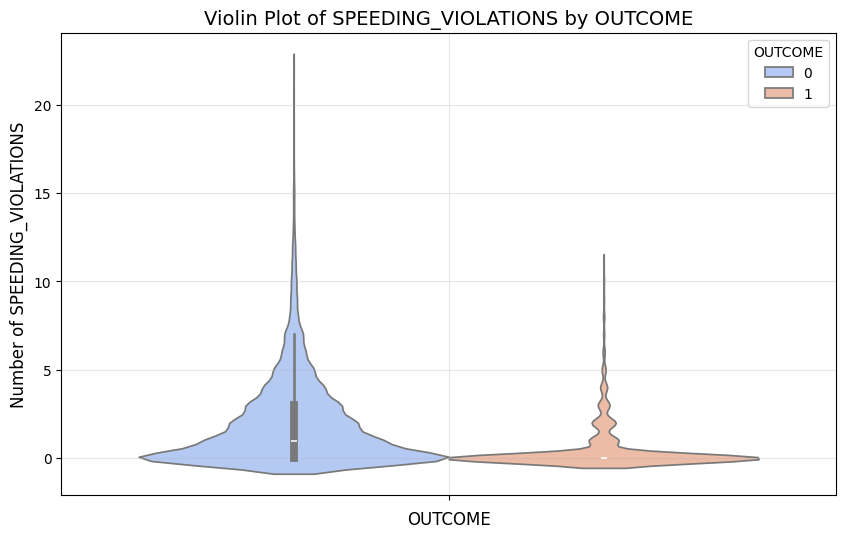

In [281]:
create_violin_plot_of_2_columns(df['OUTCOME'], df['SPEEDING_VIOLATIONS'])

### Relation between Past Accidents and Outcome

In [282]:
def create_histogram_of_accidents_and_outcome_relations(past_accidents: pd.Series, outcome: pd.Series):
    plt.figure(figsize=(10, 6))
    plt.title('Histogram of Past Accidents and Outcome Relations', fontsize=14)

    # Plot the histogram with count plot
    ax = sns.countplot(
        x=past_accidents,
        hue=outcome,
        palette='coolwarm'
    )

    # Calculate percentages for OUTCOME = 1
    percentage_dict = {}
    for value in past_accidents.unique():
        # Align both Series with the DataFrame indices
        count = past_accidents[(past_accidents == value) & (outcome == 1)].shape[0]  # Count where OUTCOME = 1
        total = past_accidents[past_accidents == value].shape[0]  # Total count for this value
        percentage_dict[value] = (count / total) * 100 if total > 0 else 0  # Calculate percentage

    # Create percentage table data
    percentage_table_data = pd.DataFrame({
        'Past Accidents': list(percentage_dict.keys()),
        '% of OUTCOME = 1': [f'{value:.1f}%' for value in percentage_dict.values()]
    }).sort_values(by=['Past Accidents'], ascending=True)

    # Add the table to the plot
    table_ax = plt.gcf().add_axes([0.75, 0.2, 0.2, 0.6])  # Adjust subplot position for the table
    table_ax.axis('tight')
    table_ax.axis('off')

    # Create the table
    table_data = percentage_table_data.values
    table_columns = percentage_table_data.columns
    table_ax.table(cellText=table_data, colLabels=table_columns, loc='center', cellLoc='center')

    # Titles and labels
    plt.xlabel('Number of Past Accidents', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    plt.show()


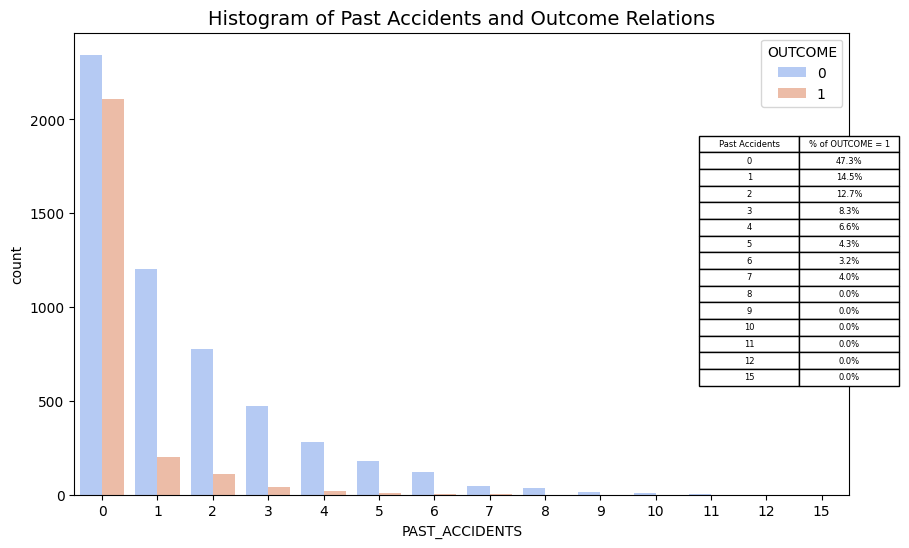

In [283]:
create_histogram_of_accidents_and_outcome_relations(df['PAST_ACCIDENTS'], df['OUTCOME'])

In [284]:
# TODO
"""
4. fix driving experience -> {more experience -> lower number}
5. add new colum "RISK_INDEX_COLUMN" = 0.4 * speeding + 0.4 * past_acc + 0.2 * driving_exp
"""

'\n4. fix driving experience -> {more experience -> lower number}\n5. add new colum "RISK_INDEX_COLUMN" = 0.4 * speeding + 0.4 * past_acc + 0.2 * driving_exp\n'

## Data Quality

### Missing data

In [285]:
# understanding where and how much missing values do we have
def how_many_missing_values(df):
    return df.isnull().sum()

In [286]:
print(how_many_missing_values(df))

GENDER                   0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           790
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         770
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
PAST_ACCIDENTS           0
AGE                      0
DRIVING_EXPERIENCE       0
OUTCOME                  0
dtype: int64


In [287]:
# filling the missing values
columns_with_missing_values = df.columns[df.isnull().any()].tolist()

imputer = KNNImputer(n_neighbors = 5)
df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])
print(how_many_missing_values(df))

GENDER                 0
EDUCATION              0
INCOME                 0
CREDIT_SCORE           0
VEHICLE_OWNERSHIP      0
VEHICLE_YEAR           0
MARRIED                0
CHILDREN               0
POSTAL_CODE            0
ANNUAL_MILEAGE         0
VEHICLE_TYPE           0
SPEEDING_VIOLATIONS    0
PAST_ACCIDENTS         0
AGE                    0
DRIVING_EXPERIENCE     0
OUTCOME                0
dtype: int64


### Irrational Data

In [288]:
def create_license_age_column(df: pd.DataFrame) -> df:
    df['LICENSE_AGE'] = df['AGE'] - df['DRIVING_EXPERIENCE']
    return df

df = create_license_age_column(df)
df['LICENSE_AGE'].describe()

count    8000.000000
mean       28.398500
std        14.518731
min         7.000000
25%        17.000000
50%        24.500000
75%        37.000000
max        79.000000
Name: LICENSE_AGE, dtype: float64

Some records indicate, based on the age and driving_experience columns, that individuals started driving at an unusually young age, which is generally not permitted in most advanced countries. To address this, we will update the driving_experience values for these records to ensure they are at least 16. The value 16 was chosen because it is both the minimum age present in the data and the legal age for obtaining a driving license in Israel.

In [289]:
df['DRIVING_EXPERIENCE'] = np.where(df['LICENSE_AGE'] < 16, df['AGE'] - 16, df['DRIVING_EXPERIENCE'])
df = create_license_age_column(df)
df['LICENSE_AGE'].describe()

count    8000.000000
mean       29.055125
std        13.811379
min        16.000000
25%        17.000000
50%        24.500000
75%        37.000000
max        79.000000
Name: LICENSE_AGE, dtype: float64

In [290]:
df = df.drop(columns = ['LICENSE_AGE']) # since it is derived from age and driving_experience, it would not contribute meaningfully to the decision tree.

## Pre-Process

### New Attributes

In [291]:
df['DRIVER_RISK_INDEX'] = 0.4 * df['SPEEDING_VIOLATIONS'] + 0.4 * df['PAST_ACCIDENTS'] + 0.2 * df['DRIVING_EXPERIENCE']
df['DRIVER_RISK_INDEX'].describe()

count    8000.000000
mean        3.966850
std         3.269105
min         0.000000
25%         1.000000
50%         3.400000
75%         6.200000
max        18.400000
Name: DRIVER_RISK_INDEX, dtype: float64

### Discretize Columns

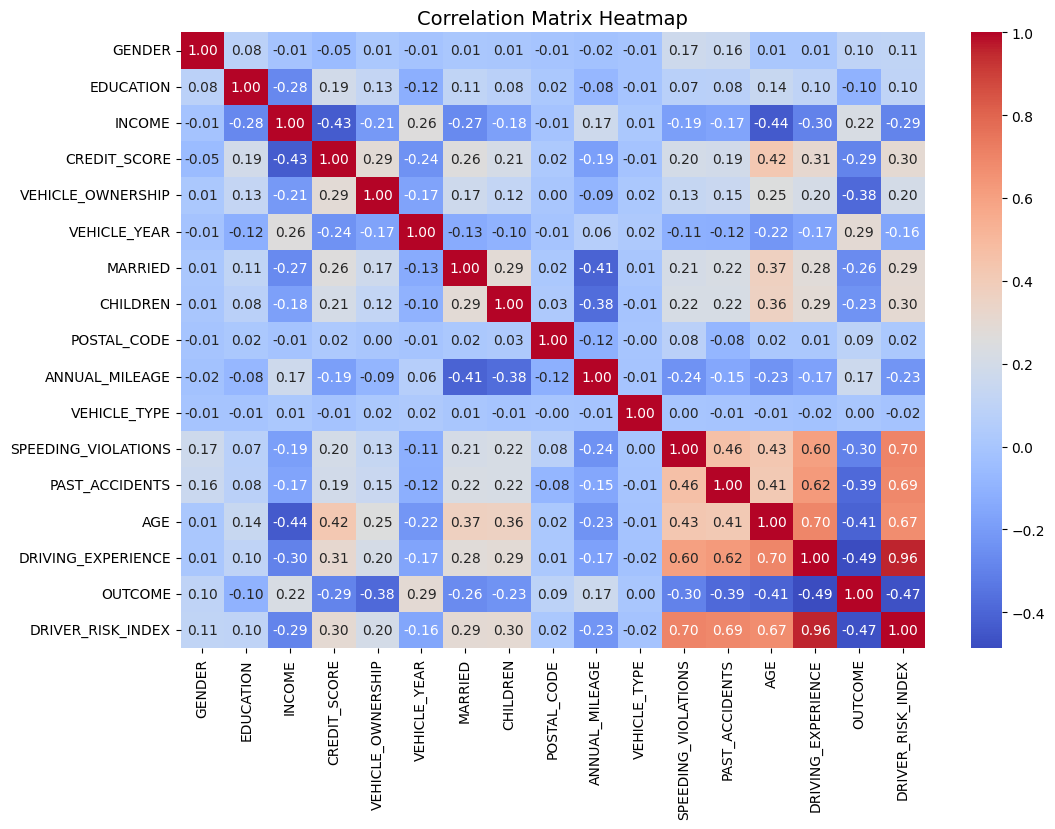

In [292]:
def get_categorial_mapping(categorical_columns: pd.DataFrame):
    indexed_mappings = {}
    for col in categorical_columns.columns:
        unique_values = df[col].unique()
        mapping = {value: idx for idx, value in enumerate(unique_values)}
        indexed_mappings[col] = mapping
    return indexed_mappings

def kbin_normal_distribution(column: pd.Series, n_bins: int = 3):
    if column.nunique() == 1:
        return pd.Series([0] * len(column), index=column.index)

    column_reshaped = column.values.reshape(-1, 1)
    n_bins = min(n_bins, column.nunique())

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*Feature 0 is constant.*")
        warnings.filterwarnings("ignore", message=".*Bins whose width are too small.*")
        kbin = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
        binned_column = kbin.fit_transform(column_reshaped).astype(int)
    return pd.Series(binned_column.flatten(), index=column.index)

def kbin_exp_distribution(column: pd.Series, n_bins: int = 3):
    if column.nunique() == 1:
        return pd.Series([0] * len(column), index=column.index)

    if column.min() <= 0:
        column = column + abs(column.min()) + 1

    log_column = np.log(column)
    column_reshaped = log_column.values.reshape(-1, 1)
    n_bins = min(n_bins, column.nunique())

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*Feature 0 is constant.*")
        warnings.filterwarnings("ignore", message=".*Bins whose width are too small.*")
        kbin = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
        binned_column = kbin.fit_transform(column_reshaped).astype(int)
    return pd.Series(binned_column.flatten(), index=column.index)

def categorize_age_attribute(age: int):
    if age <= 30: return 'young'
    elif age <= 60: return 'grown-up'
    return 'old'

def categorize_driving_experience(years: int):
    if years <= 2: return 'new'
    elif years <= 8: return 'regular'
    return 'senior'

def categorize_attributes(df: pd.DataFrame) -> pd.DataFrame:
    categorical_columns = df.select_dtypes(exclude=['float64', 'int64'])
    categorial_mapping = get_categorial_mapping(categorical_columns)
    
    for col, mapping in categorial_mapping.items():
        df[col] = df[col].map(mapping)
            
    df['CREDIT_SCORE'] = kbin_normal_distribution(df['CREDIT_SCORE'])
    df['ANNUAL_MILEAGE'] = kbin_normal_distribution(df['ANNUAL_MILEAGE'])
    df['SPEEDING_VIOLATIONS'] = kbin_exp_distribution(df['SPEEDING_VIOLATIONS'])
    df['PAST_ACCIDENTS'] = kbin_exp_distribution(df['PAST_ACCIDENTS'])
    # before assigning text to driving exp and age
    correlation_matrix = df.corr()
    create_correlation_heat_map(correlation_matrix)
    df['AGE'] = df['AGE'].apply(categorize_age_attribute)
    df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].apply(categorize_driving_experience)
    return df

df = categorize_attributes(df)